<a href="https://colab.research.google.com/github/Suraj6769/Customer_churn_Prediction/blob/main/Customer_churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Introduction

A manager at the bank is disturbed with more and more customers leaving their credit card services. They would really appreciate if one could predict for them who is going to get churned so they can proactively go to the customer to provide them better services and turn customers' decisions in the opposite direction.

This dataset consists of 10,000 customers mentioning their age, salary, marital_status, credit card limit, credit card category, etc. There are nearly 18 features.

We have only 16.07% of customers who have churned. Thus, it's a bit difficult to train our model to predict churning customers.

#Library and Utilities

In [3]:
!pip install --upgrade scipy
#Fixed: Upgraded scipy to the latest version
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as ex
import plotly.graph_objs as go

import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import plotly.offline as pyo
pyo.init_notebook_mode()

sns.set_style('darkgrid')
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score as f1

from sklearn.metrics import confusion_matrix
#import scikitplot as skplt #Fixed: Installed and imported the scikit-plot library

plt.rc('figure', figsize=(18,9))
from imblearn.over_sampling import SMOTE

#Loading the data

In [4]:
data = pd.read_csv('/content/BankChurners.csv')
data = data[data.columns[:-2]]
data.head(3)

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   

   Months_on_book  ...  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0              39  ...                       1                      3   
1              44  ...                       1                      2   
2              36  ...                       1                      0   

   Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0       12691.0                  777          11914.0                 1.335   
1        8256.0                  864           7392.0                 1.541   
2        3418.0                    0           3418.0                 2.594   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1144              42                1.625                  0.061  
1             1291              33                3.714                  0.105  
2             1887              20                2.333                  0.000  

[3 rows x 21 columns]

In [5]:
data.shape

(10127, 21)

In [6]:
pip install plotly


In [7]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Set renderer to 'colab' for Google Colab
pio.renderers.default = 'colab'

# Create subplots with 2 rows and 1 column
fig = make_subplots(rows=2, cols=1)

# Create the Box plot and Histogram
tr1 = go.Box(x=data['Customer_Age'], name='Age Box Plot', boxmean=True)
tr2 = go.Histogram(x=data['Customer_Age'], name='Age Histogram')

# Add traces to respective subplots
fig.add_trace(tr1, row=1, col=1)
fig.add_trace(tr2, row=2, col=1)

# Update the layout of the figure
fig.update_layout(height=700, width=1200, title_text='Distribution of Customer Ages')

# Show the figure
fig.show()


We can see that the distribution of customer ages in our dataset follows a fairly normal distribution; thus, further use of the age feature can be done with the normality assumption.

In [8]:
fig = make_subplots(rows=2, cols=2, subplot_titles=['Platinum Card Holders', 'Blue Card Holders', 'Residuals'],
                   vertical_spacing=0.09,
                   specs=[[{"type": "pie", "rowspan": 2}, {"type": "pie"}],
                          [None, {"type": "pie"}]])

fig.add_trace(go.Pie(values=data.Gender.value_counts().values, labels=['Female', 'Male'], hole=0.3, pull=[0,0.3]),
              row=1, col=1)

fig.add_trace(go.Pie(labels=['Female Platinum Card Holders', 'Male Platinum Card Holders'],
                   values=data.query("Card_Category=='Platinum'").Gender.value_counts().values,
                   pull=[0,0.05,0.5],
                   hole=0.3),
              row=1, col=2)

fig.add_trace(go.Pie(labels=['Female Blue Card Holders', 'Male Blue Card Holders'],
                   values=data.query('Card_Category=="Blue"').Gender.value_counts().values,
                   pull=[0,0.2,0.5],
                   hole=0.3),
              row=2, col=2)
fig.update_layout(
    height=800,
    showlegend=True,
    title_text="<b>Distribution of Gender And Different Card Statuses</b>"
)

fig.show()

More samples of females in our dataset are compared to males, but the percentage of difference is not that significant, so we can say that genders are uniformly distributed.


In [9]:
ex.pie(data, names='Education_Level', title="Proportion Of Different Education Level", hole=0.33)

If most of the customers with unknown education status lack any education, we can state that more than 70% of the customers have a formal education level. About 35% have a higher level of education.

In [10]:
ex.pie(data, names='Marital_Status', title="Proportion Of Different Marital Status", hole=0.33)

Almost half of the bank customers are married, and interestingly enough, almost the entire other half are single customers. Only about 7% of the customers are divorced, which is surprising considering the worldwide divorce rate statistics! (Let me know where the bank is located and sign me up!)

In [11]:
fig = make_subplots(rows=2, cols=1)

tr1 = go.Box(x=data['Dependent_count'], name="Dependent count Box Plot", boxmean=True)
tr2 = go.Histogram(x=data['Dependent_count'], name="Dependent count Histogram")

fig.add_trace(tr1, row=1, col=1)
fig.add_trace(tr2, row=2, col=1)

fig.update_layout(height=700, width=1200, title_text="Distribution of Dependent counts (close family size)")
fig.show()

The distribution of Dependent counts is fairly normally distributed with a slight right skew.

In [12]:
ex.pie(data, names='Income_Category', title="Proportion Of Different Income Levels", hole=0.33)

In [13]:
ex.pie(data, names='Card_Category', title="Proportion Of Different Card Categories", hole=0.33)

In [14]:
fig = make_subplots(rows=2, cols=1)

tr1 = go.Box(x=data['Months_on_book'], name="Months on book Box Plot", boxmean=True)
tr2 = go.Histogram(x=data['Months_on_book'], name="Months on book Histogram")

fig.add_trace(tr1, row=1, col=1)
fig.add_trace(tr2, row=2, col=1)

fig.update_layout(height=700, width=1200, title_text="Distribution of months the customer is part of the bank")
fig.show()

In [15]:
print('Kurtosis of months on book features is : {}'.format(data['Months_on_book'].kurtosis()))


Kurtosis of months on book features is : 0.40010012019986707


We have a low kurtosis value pointing to a very flat-shaped distribution (as shown in the plots above as well), meaning we cannot assume normality of the feature.

In [16]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots # Changed this line

# Assuming you have a DataFrame named 'c_data' with a column 'Months_Inactive_12_mon'

# Create box plot and histogram traces
tr1 = go.Box(x=data['Months_Inactive_12_mon'], name="number of months inactive Box Plot", boxmean=True)
tr2 = go.Histogram(x=data['Months_Inactive_12_mon'], name="number of months inactive Histogram")

# Create figure with two subplots
fig = make_subplots(rows=2, cols=1)

# Add traces to the figure
fig.add_trace(tr1, row=1, col=1)
fig.add_trace(tr2, row=2, col=1)

# Update layout and show the figure
fig.update_layout(height=700, width=1200, title_text="Distribution of the number of months inactive in the last 12 months")
fig.show()

In [17]:

# Create box plot and histogram traces
tr1 = go.Box(x=data['Credit_Limit'], name="Credit Limit Box Plot", boxmean=True)
tr2 = go.Histogram(x=data['Credit_Limit'], name="Credit Limit Histogram")

# Create figure with two subplots
fig = make_subplots(rows=2, cols=1)

# Add traces to the figure
fig.add_trace(tr1, row=1, col=1)
fig.add_trace(tr2, row=2, col=1)

# Update layout and show the figure
fig.update_layout(height=700, width=1200, title_text="Distribution of the Credit Limit")
fig.show()

In [18]:
# Create box plot and histogram traces
tr1 = go.Box(x=data['Total_Trans_Amt'], name="Total Trans Amt Box Plot", boxmean=True)
tr2 = go.Histogram(x=data['Total_Trans_Amt'], name="Total Trans Amt Histogram")

# Create figure with two subplots
fig = make_subplots(rows=2, cols=1)

# Add traces to the figure
fig.add_trace(tr1, row=1, col=1)
fig.add_trace(tr2, row=2, col=1)

# Update layout and show the figure
fig.update_layout(height=700, width=1200, title_text="Distribution of the Total Transaction Amount (Last 12 months)")
fig.show()

We see that the distribution of the total transactions (Last 12 months) displays a multimodal distribution, meaning we have some underlying groups in our data; it can be an interesting experiment to try and cluster the different groups and view the similarities between them and what describes best the different groups which create the different modes in our distribution.


In [19]:
# Assuming you have a DataFrame named 'data' with a column 'Attrition_Flag'

# Create pie chart using Plotly Express
ex.pie(data, names='Attrition_Flag', title='Proportion of churn vs not churn customers', hole=0.33)

As we can see, only 16% of the data samples represent churn customers. In the following steps, I will use SMOTE to upsample the churn samples to match them with the regular customer sample size to give the later selected models a better chance of catching on small details which will almost definitely be missed out with such a size difference

# Data Preparation


In [20]:
import pandas as pd

# Assuming you have a DataFrame named 'data'

# Convert categorical variables to numerical values
data['Attrition_Flag'] = data['Attrition_Flag'].replace({'Attrited Customer': 1, 'Existing Customer': 0})
data['Gender'] = data['Gender'].replace({'F': 1, 'M': 0})

# Perform one-hot encoding for categorical variables
data = pd.concat([data, pd.get_dummies(data['Education_Level']).drop(columns=['Unknown'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['Income_Category']).drop(columns=['Unknown'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['Marital_Status']).drop(columns=['Unknown'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['Card_Category']).drop(columns=['Platinum'])], axis=1)

# Drop original categorical variables
data.drop(columns=['Education_Level', 'Income_Category', 'Marital_Status', 'Card_Category', 'CLIENTNUM'], inplace=True)

**Here we one hot encode all the categorical features describing different statuses of a customer.**

*Pearson product moment correlation*

The Pearson correlation evaluates the linear relationship between two continuous variables. A relationship is linear when a change in one variable is associated with a proportional change in the other variable.

*Spearman rank-order correlation*

The Spearman correlation evaluates the monotonic relationship between two continuous or ordinal variables. In a monotonic relationship, the variables tend to change together, but not necessarily at a constant rate. The Spearman correlation coefficient is based on the ranked values for each variable rather than the raw data.

Spearman correlation is often used to evaluate relationships involving ordinal variables.

In [21]:
import plotly.graph_objs as go
import plotly.subplots

# Assuming you have a DataFrame named 'data'

# Create heatmap for Pearson correlation
s_val = data.corr('pearson')
s_idx = s_val.index
s_col = s_val.columns
s_vals = s_val.values

# Call the make_subplots function using plotly.subplots
fig = plotly.subplots.make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=('Pearson Correlation', 'Spearman Correlation'))

fig.add_trace(go.Heatmap(x=s_col, y=s_idx, z=s_vals, name='Pearson', showscale=False, xgap=0.7, ygap=0.7),
              row=1, col=1)

# Create heatmap for Spearman correlation
s_val = data.corr('spearman')
s_idx = s_val.index
s_col = s_val.columns
s_vals = s_val.values

fig.add_trace(go.Heatmap(x=s_col, y=s_idx, z=s_vals, xgap=0.7, ygap=0.7),
              row=2, col=1)

# Update hover label settings
fig.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    )
)

# Update layout settings for height, width, and title
fig.update_layout(height=708, width=980, title_text="Numeric Correlations")

# Show the figure
fig.show()

##Data Upsampling Using SMOTE
SMOTE: Synthetic Minority Oversampling Technique
SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. This algorithm helps to overcome the overflitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.


In [22]:
# Oversample using SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(data[data.columns[1:]], data[data.columns[0]])

# Create a new DataFrame with the upsampled data
usampled_df = X.assign(Churn=y)
# Create a copy of the upsampled DataFrame for one-hot encoding
ohe_data = usampled_df[usampled_df.columns[15:-1]].copy()

# Drop the original categorical variables from the upsampled DataFrame
usampled_df = usampled_df.drop(columns=usampled_df.columns[15:-1])

In [25]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Corrected Subplot Titles
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=('Pearson Correlation', 'Spearman Correlation'))

# Corrected Colorscale
colorscale = [
    [1.0 ,"rgb(165,0,38)"],
    [0.8888888888888888, "rgb(215,48,39)"],
    [0.7777777777777778, "rgb(244,109,67)"],
    [0.6666666666666666, "rgb(253,174,97)"],
    [0.5555555555555556, "rgb(254,224,144)"],
    [0.4444444444444444, "rgb(224,243,248)"],
    [0.3333333333333333, "rgb(171,217,233)"],
    [0.2222222222222222, "rgb(116,173,209)"],
    [0.1111111111111111, "rgb(69,117,180)"],
    [0.0 ,"rgb(49,54,149)"]
]

# Pearson Correlation
p_val = usampled_df.corr('pearson')
p_idx = p_val.index
p_col = p_val.columns
p_val = p_val.values

fig.add_trace(
    go.Heatmap(
        x=p_col, y=p_idx, z=p_val,
        name="pearson", showscale=False,
        xgap=1, ygap=1, colorscale=colorscale
    ),
    row=1, col=1
)

# Spearman Correlation
s_val = usampled_df.corr('spearman')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values

fig.add_trace(
    go.Heatmap(
        x=s_col, y=s_idx, z=s_val,
        name="spearman", showscale=False,
        xgap=1, ygap=1, colorscale=colorscale
    ),
    row=2, col=1
)

# Show figure
fig.show()


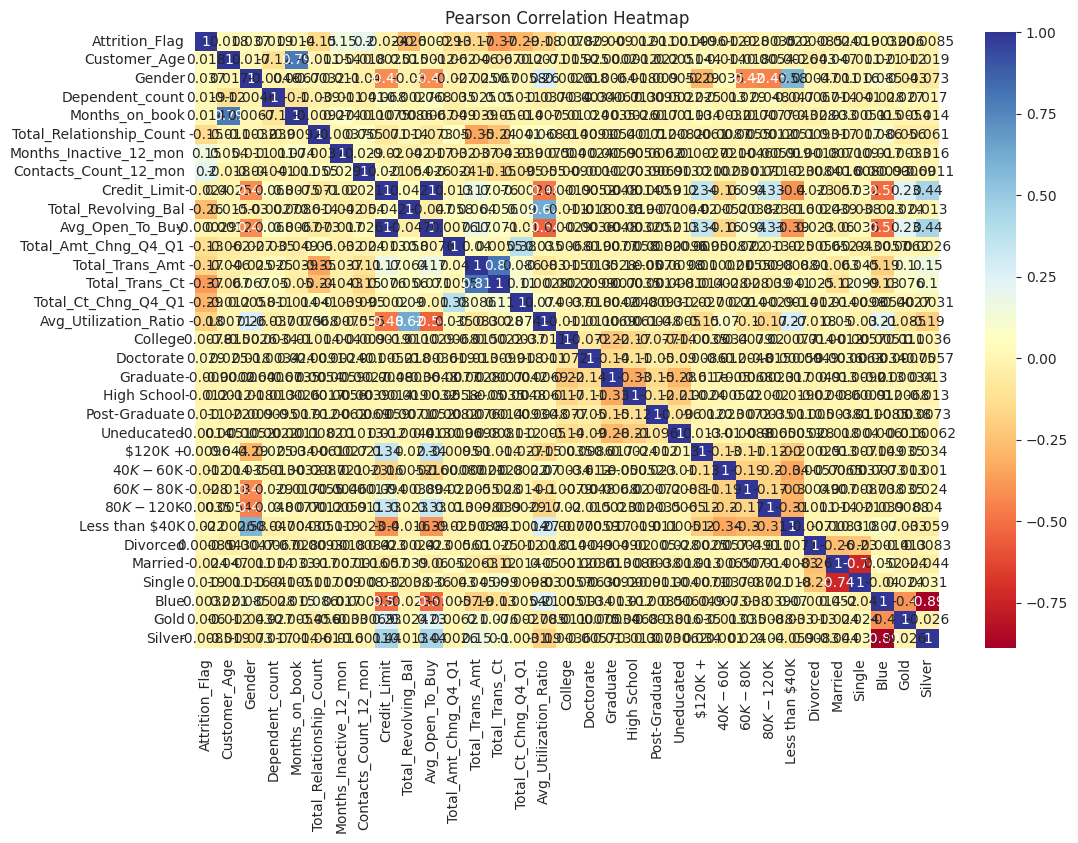

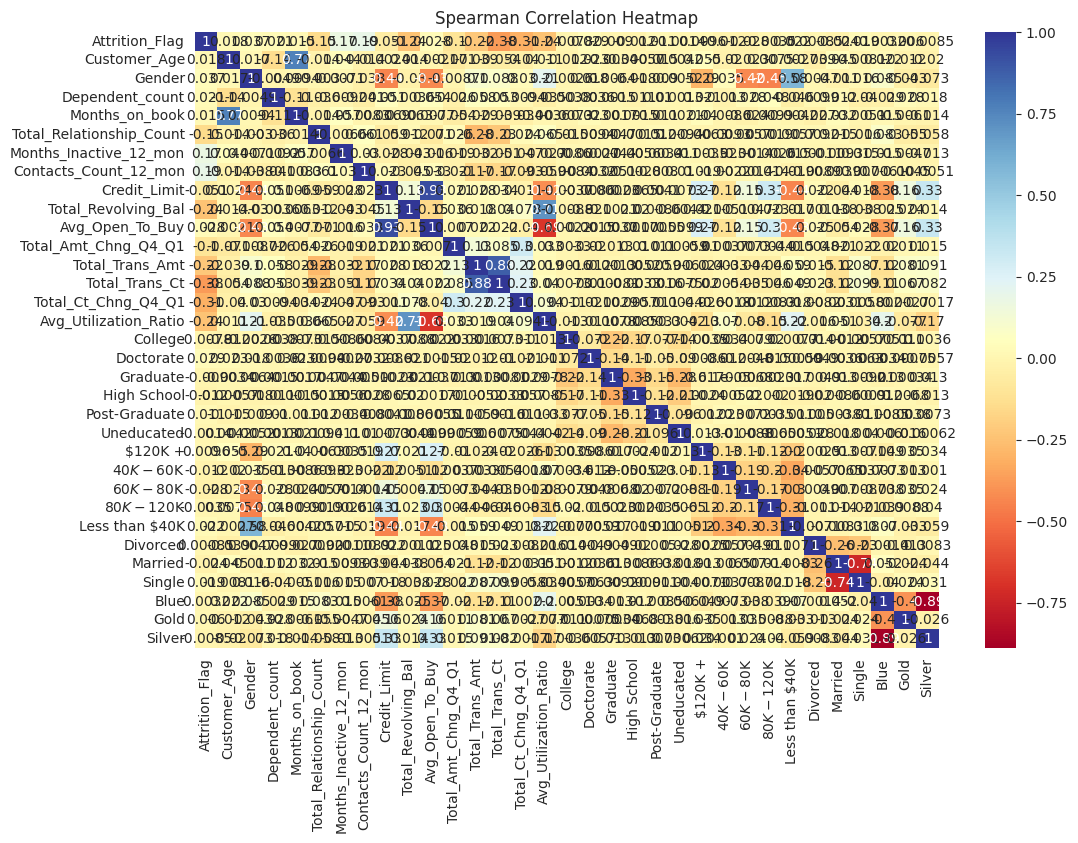

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'data'

# Create heatmap for Pearson correlation
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr('pearson'), annot=True, cmap='RdYlBu')
plt.title('Pearson Correlation Heatmap')
plt.show()

# Create heatmap for Spearman correlation
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr('spearman'), annot=True, cmap='RdYlBu')
plt.title('Spearman Correlation Heatmap')
plt.show()

#**Principal component analysis of One Hot Encoding Data**

We will use principal component analysis to reduce the dimensionality of the one-hot encoded categorical variables losing some of the variances, but simultaneously, using a couple of principal components instead of tens of one-hot encoded features will help me construct a better model.

In [27]:
import plotly.graph_objs as go

# Assuming you have a DataFrame named 'ohe_data'

# Set the number of principal components
N_COMPONENTS = 4

# Create PCA model
pca_model = PCA(n_components=N_COMPONENTS)

# Fit and transform the data
pc_matrix = pca_model.fit_transform(ohe_data)

# Calculate explained variance ratio and total variance
evr = pca_model.explained_variance_ratio_
total_var = evr.sum() * 100
cumsum_evr = np.cumsum(evr)
trace1 = {
    "name": "individual explained variance",
    "type": "bar",
    "y": evr
}
trace2 = {
    "name": "cumulative explained variance",
    "type": "scatter",
    "y": cumsum_evr
}
data1 = [trace1, trace2]
layout = {
    "xaxis": {"title": "Principal components"},
    "yaxis": {"title": "Explained variance ratio"}
}
fig = go.Figure(data=data1, layout=layout)
fig.update_layout(
    title="Explained Variance Using {} Dimensions".format(N_COMPONENTS)
)
fig.show()


In [28]:
data.head()

Attrition_Flag  Customer_Age  Gender  Dependent_count  Months_on_book  \
0               0            45       0                3              39   
1               0            49       1                5              44   
2               0            51       0                3              36   
3               0            40       1                4              34   
4               0            40       0                3              21   

   Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0                         5                       1                      3   
1                         6                       1                      2   
2                         4                       1                      0   
3                         3                       4                      1   
4                         5                       1                      0   

   Credit_Limit  Total_Revolving_Bal  ...  $40K - $60K  $60K - $80K  \
0       12691.0                  777  ...        False         True   
1        8256.0                  864  ...        False        False   
2        3418.0                    0  ...        False        False   
3        3313.0                 2517  ...        False        False   
4        4716.0                    0  ...        False         True   

   $80K - $120K  Less than $40K  Divorced  Married  Single  Blue   Gold  \
0         False           False     False     True   False  True  False   
1         False            True     False    False    True  True  False   
2          True           False     False     True   False  True  False   
3         False            True     False    False   False  True  False   
4         False           False     False     True   False  True  False   

   Silver  
0   False  
1   False  
2   False  
3   False  
4   False  

[5 rows x 33 columns]

In [29]:
# Concatenate the original DataFrame with the principal component matrix
usampled_df_with_pcs = pd.concat([usampled_df, pd.DataFrame(pc_matrix, columns=['PC-{}'.format(i) for i in range(N_COMPONENTS)])], axis=1)


In [30]:
import plotly.express as px

# Create scatter matrix using Plotly Express
fig = px.scatter_matrix(
    usampled_df_with_pcs,
    dimensions=[f'PC-{i}' for i in range(N_COMPONENTS)],  # Dimensions for principal components
    color='Credit_Limit',  # Column for coloring the points
    title=f'Total Explained Variance: {total_var:.2f}%'  # Title with total explained variance
)

# Hide diagonal plots
fig.update_traces(diagonal_visible=False)

# Update layout for colorbar
fig.update_layout(
    coloraxis_colorbar=dict(
        title="Credit_Limit"
    )
)

# Show the figure
fig.show()


In [31]:
data.head()


Attrition_Flag  Customer_Age  Gender  Dependent_count  Months_on_book  \
0               0            45       0                3              39   
1               0            49       1                5              44   
2               0            51       0                3              36   
3               0            40       1                4              34   
4               0            40       0                3              21   

   Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0                         5                       1                      3   
1                         6                       1                      2   
2                         4                       1                      0   
3                         3                       4                      1   
4                         5                       1                      0   

   Credit_Limit  Total_Revolving_Bal  ...  $40K - $60K  $60K - $80K  \
0       12691.0                  777  ...        False         True   
1        8256.0                  864  ...        False        False   
2        3418.0                    0  ...        False        False   
3        3313.0                 2517  ...        False        False   
4        4716.0                    0  ...        False         True   

   $80K - $120K  Less than $40K  Divorced  Married  Single  Blue   Gold  \
0         False           False     False     True   False  True  False   
1         False            True     False    False    True  True  False   
2          True           False     False     True   False  True  False   
3         False            True     False    False   False  True  False   
4         False           False     False     True   False  True  False   

   Silver  
0   False  
1   False  
2   False  
3   False  
4   False  

[5 rows x 33 columns]

In [32]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Assuming you have DataFrame named 'usampled_df_with_pcs'

# Define the colorscale
colorscale = [
    [1.0 ,"rgb(165,0,38)"],
    [0.8888888888888888, "rgb(215,48,39)"],
    [0.7777777777777778, "rgb(244,109,67)"],
    [0.6666666666666666, "rgb(253,174,97)"],
    [0.5555555555555556, "rgb(254,224,144)"],
    [0.4444444444444444, "rgb(224,243,248)"],
    [0.3333333333333333, "rgb(171,217,233)"],
    [0.2222222222222222, "rgb(116,173,209)"],
    [0.1111111111111111, "rgb(69,117,180)"],
    [0.0 ,"rgb(49,54,149)"]
]

# Create figure with two subplots
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=('Pearson Correlation', 'Spearman Correlation'))

# Pearson Correlation Heatmap
p_val = usampled_df_with_pcs.corr('pearson')
p_idx = p_val.index
p_col = p_val.columns
p_vals = p_val.values

# Add Pearson correlation heatmap
fig.add_trace(
    go.Heatmap(
        x=p_col, y=p_idx, z=p_vals,
        name='Pearson', showscale=False,
        xgap=1, ygap=1, colorscale=colorscale
    ),
    row=1, col=1
)

# Spearman Correlation Heatmap
s_val = usampled_df_with_pcs.corr('spearman')
s_idx = s_val.index
s_col = s_val.columns
s_vals = s_val.values

# Add Spearman correlation heatmap
fig.add_trace(
    go.Heatmap(
        x=s_col, y=s_idx, z=s_vals,
        xgap=1, ygap=1, colorscale=colorscale
    ),
    row=2, col=1
)

# Update hover label settings
fig.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    )
)

# Update layout settings for height, width, and title
fig.update_layout(
    height=700,
    width=900,
    title_text="Upsampled Correlations with PC's"
)

# Show the figure
fig.show()


##Model Selection

In [33]:
# Define the features to be used
X_features = ['Total_Trans_Ct', 'PC-3', 'PC-1', 'PC-0', 'PC-2', 'Total_Ct_Chng_Q4_Q1', 'Total_Relationship_Count']

# Create X and y variables
X = usampled_df_with_pcs[X_features]
y = usampled_df_with_pcs['Churn']

In [34]:
# Split the data into training and testing sets
train_x, test_x, train_y, test_y = train_test_split(X, y, random_state=42)

# Cross Validation

In [35]:

# Create pipelines for different models with unique step names
rf_pipe = Pipeline(steps=[('scale', StandardScaler()), ('rf', RandomForestClassifier(random_state=42))])
ada_pipe = Pipeline(steps=[('scale', StandardScaler()), ('ada', AdaBoostClassifier(random_state=42, learning_rate=0.7))])
svm_pipe = Pipeline(steps=[('scale', StandardScaler()), ('svc', SVC(random_state=42, kernel='rbf'))])
logreg_pipe = Pipeline(steps=[('scale', StandardScaler()), ('logreg', LogisticRegression(random_state=42))])
gboost_pipe = Pipeline(steps=[('scale', StandardScaler()), ('gboost', GradientBoostingClassifier(random_state=42))])

# Perform cross-validation for each model
rf_f1_cross_val_scores = cross_val_score(rf_pipe, train_x, train_y, cv=5, scoring='f1')
ada_f1_cross_val_scores = cross_val_score(ada_pipe, train_x, train_y, cv=5, scoring='f1')
svm_f1_cross_val_scores = cross_val_score(svm_pipe, train_x, train_y, cv=5, scoring='f1')
logreg_f1_cross_val_scores = cross_val_score(logreg_pipe, train_x, train_y, cv=5, scoring='f1')
gboost_f1_cross_val_scores = cross_val_score(gboost_pipe, train_x, train_y, cv=5, scoring='f1')

# Print results
print(f"Random Forest F1 Scores: {rf_f1_cross_val_scores}")
print(f"AdaBoost F1 Scores: {ada_f1_cross_val_scores}")
print(f"SVM F1 Scores: {svm_f1_cross_val_scores}")
print(f"Logistic Regression F1 Scores: {logreg_f1_cross_val_scores}")
print(f"Gradient Boosting F1 Scores: {gboost_f1_cross_val_scores}")


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: Fu

Random Forest F1 Scores: [0.90666667 0.91223928 0.91453674 0.9084507  0.91506849]
AdaBoost F1 Scores: [0.86946387 0.875      0.87956061 0.86883365 0.8829664 ]
SVM F1 Scores: [0.8657188  0.87795276 0.87793241 0.86762983 0.87490165]
Logistic Regression F1 Scores: [0.81149154 0.8233463  0.81825397 0.80546875 0.82069234]
Gradient Boosting F1 Scores: [0.8933177  0.89644392 0.90419636 0.89088075 0.89539422]


In [36]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots  # Correct import
import plotly.io as pio

# Set the default renderer to 'colab' for Google Colab
pio.renderers.default = 'colab'

# Create subplots with 5 rows
fig = make_subplots(
    rows=5, cols=1, shared_xaxes=True,
    subplot_titles=('Random Forest Cross Val Scores',
                    'Adaboost Cross Val Scores',
                    'SVM Cross Val Scores',
                    'Logistic Regression Cross Val Scores',
                    'Gradient Boosting Cross Val Scores')
)

# Add scatter plots for each model's cross-validation scores
fig.add_trace(go.Scatter(x=list(range(len(rf_f1_cross_val_scores))), y=rf_f1_cross_val_scores, name='Random Forest'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(len(ada_f1_cross_val_scores))), y=ada_f1_cross_val_scores, name='Adaboost'), row=2, col=1)
fig.add_trace(go.Scatter(x=list(range(len(svm_f1_cross_val_scores))), y=svm_f1_cross_val_scores, name='SVM'), row=3, col=1)
fig.add_trace(go.Scatter(x=list(range(len(logreg_f1_cross_val_scores))), y=logreg_f1_cross_val_scores, name='Logistic Regression'), row=4, col=1)
fig.add_trace(go.Scatter(x=list(range(len(gboost_f1_cross_val_scores))), y=gboost_f1_cross_val_scores, name='Gradient Boosting'), row=5, col=1)

# Update layout for the figure
fig.update_layout(
    height=900,
    width=900,
    title_text="Different Model 5-Fold Cross Validation"
)

# Update Y-axis titles
fig.update_yaxes(title_text="F1 Score", row=1, col=1)
fig.update_yaxes(title_text="F1 Score", row=2, col=1)
fig.update_yaxes(title_text="F1 Score", row=3, col=1)
fig.update_yaxes(title_text="F1 Score", row=4, col=1)
fig.update_yaxes(title_text="F1 Score", row=5, col=1)

# Update X-axis title (shared across subplots)
fig.update_xaxes(title_text="Fold #")

# Show the figure
fig.show()


#Model Evaluation


In [37]:
import plotly.graph_objs as go
import numpy as np  # Import numpy
from sklearn.metrics import f1_score  # Import f1_score

# Assuming you have variables 'rf_pipe', 'ada_pipe', 'svm_pipe', 'train_x', 'train_y', 'test_x', and 'test_y'

# Fit the models and make predictions
rf_pipe.fit(train_x, train_y)
rf_prediction = rf_pipe.predict(test_x)

ada_pipe.fit(train_x, train_y)
ada_prediction = ada_pipe.predict(test_x)

svm_pipe.fit(train_x, train_y)
svm_prediction = svm_pipe.predict(test_x)

logreg_pipe.fit(train_x, train_y)
logreg_prediction = logreg_pipe.predict(test_x)

gboost_pipe.fit(train_x, train_y)
gboost_prediction = gboost_pipe.predict(test_x)

# Calculate F1 scores
rf_f1 = np.round(f1_score(test_y, rf_prediction), 2)
ada_f1 = np.round(f1_score(test_y, ada_prediction), 2)
svm_f1 = np.round(f1_score(test_y, svm_prediction), 2)
logreg_f1 = np.round(f1_score(test_y, logreg_prediction), 2)
gboost_f1 = np.round(f1_score(test_y, gboost_prediction), 2)

# Create the table for F1 scores
fig = go.Figure(data=[go.Table(
    header=dict(values=['Model', 'F1 Score On Test Data'],
                line_color='darkslategray',
                fill_color='whitesmoke',
                align=['center', 'center'],
                font=dict(color='black', size=18),
                height=40),
    cells=dict(values=[
        ['Random Forest', 'AdaBoost', 'SVM', 'Logistic Regression', 'Gradient Boosting'],
        [rf_f1, ada_f1, svm_f1, logreg_f1, gboost_f1]
    ])
)])

# Update layout and show the figure
fig.update_layout(title="Model Results on Test Data")
fig.show()


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



#MODEL EVALUATION ON ORIGINAL DATA(BEFORE UPSAMPLING)

In [38]:
data.head()

Attrition_Flag  Customer_Age  Gender  Dependent_count  Months_on_book  \
0               0            45       0                3              39   
1               0            49       1                5              44   
2               0            51       0                3              36   
3               0            40       1                4              34   
4               0            40       0                3              21   

   Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0                         5                       1                      3   
1                         6                       1                      2   
2                         4                       1                      0   
3                         3                       4                      1   
4                         5                       1                      0   

   Credit_Limit  Total_Revolving_Bal  ...  $40K - $60K  $60K - $80K  \
0       12691.0                  777  ...        False         True   
1        8256.0                  864  ...        False        False   
2        3418.0                    0  ...        False        False   
3        3313.0                 2517  ...        False        False   
4        4716.0                    0  ...        False         True   

   $80K - $120K  Less than $40K  Divorced  Married  Single  Blue   Gold  \
0         False           False     False     True   False  True  False   
1         False            True     False    False    True  True  False   
2          True           False     False     True   False  True  False   
3         False            True     False    False   False  True  False   
4         False           False     False     True   False  True  False   

   Silver  
0   False  
1   False  
2   False  
3   False  
4   False  

[5 rows x 33 columns]

In [39]:
# Create a copy of the original data, excluding non-numeric columns
numeric_data = data.select_dtypes(include=[np.number]).copy()


In [40]:
from sklearn.preprocessing import OneHotEncoder

# Identify non-numeric columns
non_numeric_columns = data.select_dtypes(exclude=[np.number]).columns

# Apply one-hot encoding to non-numeric columns
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Corrected argument name and usage
encoded_columns = encoder.fit_transform(data[non_numeric_columns])

# Create a DataFrame with encoded columns
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(non_numeric_columns))

# Concatenate encoded columns with numeric data
numeric_data = pd.concat([data.select_dtypes(include=[np.number]), encoded_df], axis=1)


In [41]:
from sklearn.decomposition import PCA

# Create PCA model
N_COMPONENTS = 4
pca_model = PCA(n_components=N_COMPONENTS)

# Perform PCA transformation
pc_matrix = pca_model.fit_transform(numeric_data)

# Concatenate the original data with the principal component matrix
original_df_with_pcs = pd.concat([data.reset_index(drop=True), pd.DataFrame(pc_matrix, columns=['PC-{}'.format(i) for i in range(N_COMPONENTS)])], axis=1)


In [42]:
# Create a copy of the original data without the target variable
# Convert data to DataFrame if it's not already
if not isinstance(data, pd.DataFrame):
    data = pd.DataFrame(data)

ohe_data = data[data.columns[16:]].copy()

# Perform PCA transformation
pc_matrix = pca_model.fit_transform(ohe_data)

# Concatenate the original data with the principal component matrix
original_df_with_pcs = pd.concat([data, pd.DataFrame(pc_matrix, columns=['PC-{}'.format(i) for i in range(N_COMPONENTS)])], axis=1)

# Make predictions on the original data using the trained models
unsampled_data_prediction_RF = rf_pipe.predict(original_df_with_pcs[X_features])
unsampled_data_prediction_ADA = ada_pipe.predict(original_df_with_pcs[X_features])
unsampled_data_prediction_SVM = svm_pipe.predict(original_df_with_pcs[X_features])
unsampled_data_prediction_LOGREG = logreg_pipe.predict(original_df_with_pcs[X_features])
unsampled_data_prediction_GBOOST = gboost_pipe.predict(original_df_with_pcs[X_features])


In [43]:
original_df_with_pcs.columns

Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'College', 'Doctorate', 'Graduate', 'High School', 'Post-Graduate',
       'Uneducated', '$120K +', '$40K - $60K', '$60K - $80K', '$80K - $120K',
       'Less than $40K', 'Divorced', 'Married', 'Single', 'Blue', 'Gold',
       'Silver', 'PC-0', 'PC-1', 'PC-2', 'PC-3'],
      dtype='object')

In [44]:
fig = go.Figure(data=[go.Table(
    header=dict(values=['<b>Model</b>', '<b>F1 Score On Original Data (Before Upsampling)</b>'],
                line_color='darkslategray',
                fill_color='whitesmoke',
                align=['center', 'center'],
                font=dict(color='black', size=18),
                height=40),
    cells=dict(values=[
        ['<b>Random Forest</b>', '<b>AdaBoost</b>', '<b>SVM</b>', '<b>Logistic Regression</b>', '<b>Gradient Boosting</b>'],
        [np.round(f1_score(unsampled_data_prediction_RF, original_df_with_pcs['Attrition_Flag']), 2),
         np.round(f1_score(unsampled_data_prediction_ADA, original_df_with_pcs['Attrition_Flag']), 2),
         np.round(f1_score(unsampled_data_prediction_SVM, original_df_with_pcs['Attrition_Flag']), 2),
         np.round(f1_score(unsampled_data_prediction_LOGREG, original_df_with_pcs['Attrition_Flag']), 2),
         np.round(f1_score(unsampled_data_prediction_GBOOST, original_df_with_pcs['Attrition_Flag']), 2)
        ]])
)])

fig.update_layout(title='Model Result On Original Data (Without Upsampling)')
fig.show()

In [45]:
z = confusion_matrix(unsampled_data_prediction_RF, original_df_with_pcs['Attrition_Flag'])
fig = ff.create_annotated_heatmap(z, x=['Not Churn', 'Churn'], y=['Predicted Not Churn', 'Predicted Churn'], colorscale='Fall', xgap=1, ygap=1)
fig['data'][0]['showscale'] = True
fig.update_layout(title='Prediction On Original Data With Random Forest Model Confusion Matrix')
fig.show()


In [46]:
!pip install scikit-plot


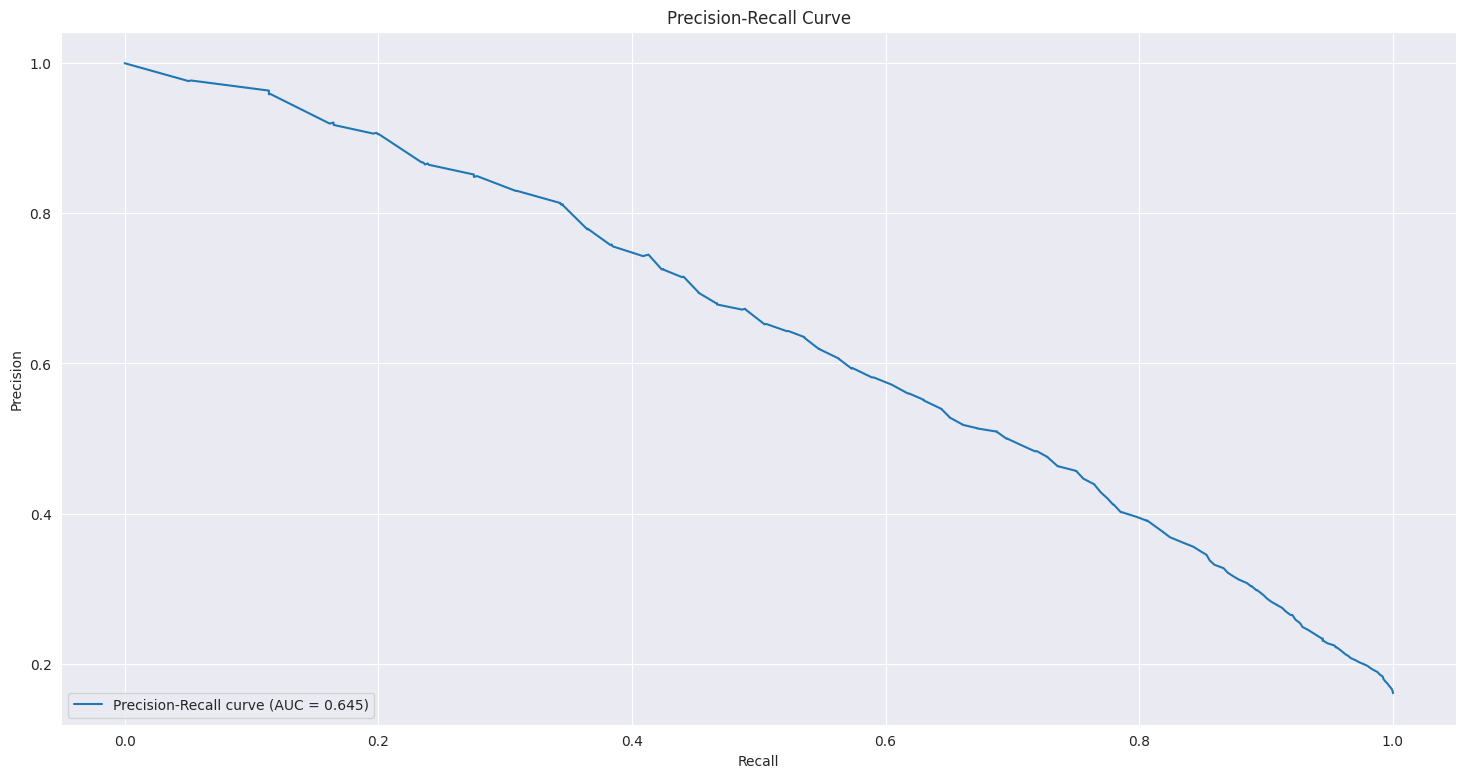

In [47]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Make probability predictions (returns probabilities for both classes)
unsampled_data_prediction_RF = rf_pipe.predict_proba(original_df_with_pcs[X_features])

# Get precision and recall values for both classes
precision, recall, _ = precision_recall_curve(original_df_with_pcs['Attrition_Flag'], unsampled_data_prediction_RF[:, 1])

# Compute AUC for precision-recall curve
auc_value = auc(recall, precision)

# Plot the precision-recall curve
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_value:.3f})')

# Plot formatting
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
